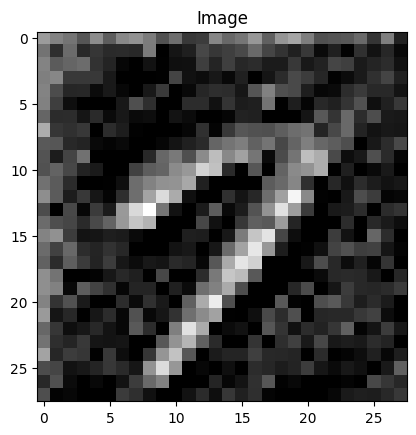

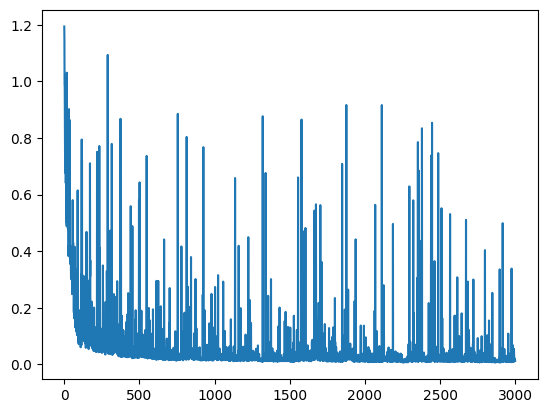

In [6]:
"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script is used to train the UNet to predict the noise at different
timestamps of the diffusion process. The loss function is a simple mean
squared error between the actual noise and the predicted noise based on
the diffused image, according to the original paper: 
https://arxiv.org/pdf/2006.11239.pdf
"""

from tqdm import tqdm, trange

import torch
from torch import optim
from diffusion_model import DiffusionProcess
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from models import UNet , ConditionalUNet

def display_image(tensor, title="Image"):
    image = tensor.squeeze(0).squeeze(0).cpu().detach().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(1, 64)
        )
        self.decoder = nn.Sequential(
            self.conv_block(64, 1)
        )
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x



if __name__ == "__main__":
    # Prepare images

    # Prepare model and training
    device = "cuda"
    prior = DIP().to(device)
    prior.load_state_dict(torch.load('DIP_sample.pth'))
    prior.eval()
    model = UNet().to(device)
    process = DiffusionProcess(variance_schedule=torch.linspace(1e-4, 0.01, steps=501))
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 80)
    criterion = torch.nn.MSELoss()
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image , _ = datasets.MNIST(root='./data', train=True, download=True, transform=transform)[15]
    noise = torch.load('input_noise.pt')
    display_image(prior(noise.to(device)))
    # Training Loop
    loss_steps = []
    for e in tqdm(range(3000),leave=False):
        diffused_image = prior(noise.to(device))
        t = torch.randint(0,500,(image.shape[0],))

        #t = torch.tensor([e%1000])
        epsilon = torch.randn(image.shape)
        diffused_image = process.forward(diffused_image.cpu(),t,epsilon)
        out = model(diffused_image.to(device) ,t.to(device))
        #image = image.reshape((1,1,28,28))
        loss = criterion(epsilon.to(device), out.to(device))
        optimizer.zero_grad()
        #optimize_DIP.zero_grad()
        loss.backward()
        optimizer.step()
        #optimize_DIP.step()
        loss_steps.append(loss.item())
        #tqdm.write(str(loss.item()))
    model.eval()

    torch.save(model.state_dict(), "Model_DIP_DDPM_modified_schedule1.pth")
    #torch.save(prior.state_dict(),"prior_mnist.pth")
    plt.plot(loss_steps)
    plt.show()